# EXP-1.2: Differing minimum biomass

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

```
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda env create -f binder/environment.yml
conda activate gud_groups
jupyter notebook
```

Once the environment gud_groups is created, the Jupyter notebook can be launched simply with:

```
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda activate gud_groups
jupyter notebook
```

# First, load libraries

In [1]:
import datetime
import math
import matplotlib as mpl
import matplotlib.patches
import matplotlib.pyplot as plt
import netcdf_tools
import numpy as np
import pandas as pd
import os
import read_mitgcm
import vstats_pos

In [2]:
plt.close("all")

# Select year

In [3]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [4]:
gridfile='grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [5]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [6]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

# Observations

## Observations: ice concentration

The values of observed sea ice concentrations were boolean values of 0
and 1 because sea ice melted suddenly in only one day.
Here, these values were retrieved from the file of the forcing fields
of sea ice concentration.
We made sure these values corresponded to the expected values.

In [7]:
infile_sic=\
'../../gud_1d_35+16/input_noradtrans/input/siarea.qik.2016.365.32bits.bin'
array1d_iT_sic=np.fromfile(infile_sic,dtype='>f')

Sea ice break-up was on 18 July 2016, doy (0-based)=199.

In [8]:
obs_breakup=next(i for i,v in list(enumerate(array1d_iT_sic)) if v==0)

assert obs_breakup==199,\
'the day of year (0-based) of break-up from the file %s (obs_breakup=%r)'\
' is different from the day of year of break-up'\
' from Oziel et al., 2019 in Elem. Sci. Anth. (July 18=199).'\
% (infile_sic,obs_breakup)

## Observations: snow and ice thickness

The file Ice thickness from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ snow and ice thickness at the Green Edge sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'sample_thickness_cm_average' is the snow or ice thickness ($cm$).

### Observations: snow and ice thickness: load dataset

In [9]:
def load_thickness():
    fname='../../obs/66407.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_thickness_cm_average': np.float32,
                'sample_thickness_cm_sd': np.float32,
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    df['sample_thickness_m_average']=df['sample_thickness_cm_average'] \
    .apply(lambda x:x/100)
    return df

In [10]:
thickness_df=load_thickness()

### Observations: snow and ice thickness: select

We select the observations of snow thickness at the ice camp 2016.

In [11]:
snow_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                               & (thickness_df.sample_type=='snow')]
# snow_thickness_df[['date','sample_thickness_m_average']]

The start of the period without observed snow cover was defined as the
start of the melt pond period.
It was on 15 June 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [12]:
obs_nosnow=166 # 0-based

We select the observations of ice thickness at the ice camp 2016.

In [13]:
ice_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                              & (thickness_df.sample_type=='ice')]

## Observations: PAR just below surface ($\mathrm{ 0^- }$)

In $\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

Conversion factor from
$\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$
to
$\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

In [14]:
uEs2Ed=1E-6*86400

The file C-OPS from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ underwater PAR at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'averaged_par_d_fit_daily_ein_m_2_day_1' is the downwelling PAR (mol photons $\mathrm{ m^{-2} }$ $\mathrm{ d^{-1} }$).

Let $\mathrm{ I_i }$ the PAR just below sea ice.

PAR just below surface ($\mathrm{ 0^- }$) was observed only just
below sea ice ($\mathrm{ I_i }$).
PAR just below surface ($\mathrm{ 0^- }$) was not observed just
below open water ($\mathrm{ I_w }$).
Observed PAR ($\mathrm{ 0^- }$) was thus equivalent to 
observed PAR just below sea ice ($\mathrm{ I_i })$.

### Observations: PAR just below sea ice ($\mathrm{ I_i }$): load dataset

In [15]:
def load_par(fname):
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [16]:
infile_PAR_iceFile='../../obs/66399.csv'
par_df=load_par(infile_PAR_iceFile)

### Observations: PAR just below sea ice ($\mathrm{ I_i }$): select

In [17]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [18]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [19]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

### Observations: PAR just below sea ice ($\mathrm{ I_i }$): calculate

The first value of simulated PAR had a depth=0 m even when there was sea ice. The first value of observed PAR had a depth equals to the thickness of sea ice in the water. For example, if there was 1 m of sea ice in the water, the first value of observed PAR would be at depth=1 m. We changed that for a depth=0 m to be coherent with the simulated values. Indeed, we wanted to compare observed and simulated PAR at the same distance from the bottom of sea ice and not at the same distance from the water surface.

In [20]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=parwater_df.loc[(parwater_df.doy==doy),('depth')].min() # m
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']-ice_thickness

In [21]:
# mol photons m^-2 d^-1
array1d_iT_obsPAR0m=np.empty(365)
array1d_iT_obsPAR0m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    array1d_iT_obsPAR0m[doy-1]=\
    parwater_df.loc[(parwater_df.doy==doy) & (parwater_df.depth==0),
                    'par']

The first observation of PAR under sea ice was on 4 May,
doy (0-based)=124.

In [22]:
first_obs_PAR=np.where(~np.isnan(array1d_iT_obsPAR0m))[0][0]
first_obs_PAR
assert first_obs_PAR==124,\
'the day of year (0-based) of the first observation of PAR under sea ice'\
' from the file %s (first_obs_PAR=%r)'\
' is different from the expected value of 124 (May 4).'\
% (infile_PAR_iceFile,first_obs_PAR)

## Observations: $\mathrm{ \sum Chl\ } a$

$\mathrm{ \sum Chl\ } a$ is the vertically integrated Chl $a$ (0-100m)
in $\mathrm{ mg\ Chl\ m^{-2} }$.

The file Pigments, nutrients, Chlorophyll a and Phaeopigments (concentration) from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ chlorophyll *a* at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'conc_mg_m3' is the chlorophyll *a* concentration measured by HPLC (mg Chl $\mathrm{ m^{-3} }$).

### Observations: $\mathrm{ \sum Chl\ } a$: load dataset

In [23]:
def load_pigment():
    fname='../../obs/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                conc_ug_l='chlfluo',
                conc_mg_m3='chlHPLC'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [24]:
chlHPLC_df=load_pigment()

### Observations: $\mathrm{ \sum Chl\ } a$: select

We select the observations of chlorophyll a concentrations at the ice camp 2016 measured by HPLC.

In [25]:
chlHPLC_df=chlHPLC_df[(chlHPLC_df.mission=='ice_camp_2016') \
              & (chlHPLC_df.sample_type=='water') \
             & (chlHPLC_df.pigment=='Total Chlorophyll a') \
             & (chlHPLC_df.method=='HPLC')]

remove negative chlorophyll a

In [26]:
chlHPLC_df['chlHPLC'][ chlHPLC_df['chlHPLC']<0 ]

Series([], Name: chlHPLC, dtype: float32)

find duplicates

In [27]:
g=chlHPLC_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

doy  depth
146  1.5      2.0
     10.0     2.0
Name: depth, dtype: float64

inspect duplicates for doy=146

In [28]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20357,0.5,0.1056,146
20358,1.5,0.0899,146
20359,5.0,0.0906,146
20360,10.0,0.0905,146
20361,20.0,0.1011,146
20362,40.0,0.0633,146
20363,0.5,0.0971,148
20364,1.5,0.1483,146
20365,5.0,0.1086,148
20366,10.0,0.0890,146


By human judgement, I replace the doy of rows 20364 and 20366 with 148.

In [29]:
chlHPLC_df.loc[[20364,20366],'doy']=148

In [30]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20357,0.5,0.1056,146
20358,1.5,0.0899,146
20359,5.0,0.0906,146
20360,10.0,0.0905,146
20361,20.0,0.1011,146
20362,40.0,0.0633,146
20363,0.5,0.0971,148
20364,1.5,0.1483,148
20365,5.0,0.1086,148
20366,10.0,0.0890,148


Identify days of year for which the number of observations is less than or equal to 2. There are not measurements at enough depths to be able to calculate a meaningful vertical integration.

In [31]:
g=chlHPLC_df.groupby('doy')['doy'].value_counts()
g.where(g<=2).dropna()

doy  doy
120  120    2.0
Name: doy, dtype: float64

In [32]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==120)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20299,1.5,0.0355,120
20300,5.0,0.0253,120


By human judgement, I drop these observations.

In [33]:
chlHPLC_df=chlHPLC_df.drop(chlHPLC_df[(chlHPLC_df.doy==120)].index)

### Observations: $\mathrm{ \sum Chl\ } a$: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [34]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    70])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  70])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    70])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         75])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    70])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,20,    55])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,20,    22.5,32.5])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45,60])
weights_case8=np.array([     5.75,        9.25,10,12.5,15,47.5])

In [35]:
nT=365
array1d_iT_obsvintchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvintchlHPLC[iT]=obsvintchlHPLC

# NEMO-LIM3

## NEMO-LIM3: simulated sea ice freeze-up

In [36]:
infile_sicFile='../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin'
array1d_iT_forsic=np.fromfile(infile_sicFile,dtype='>f4')

The simulated sea ice freeze-up was on 24 November, doy (0-based)=328.

In [37]:
sim_freezeup\
=next(i for i,v in reversed(list(enumerate(array1d_iT_forsic))) if v < 0.50)

In [38]:
sim_freezeup

328

# Model

## Model: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ was the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.
It included all groups of numerical phytoplankton (diatoms+dinoflagellates+other nanophytoplankton+picophytoplankton).
Note that picophytoplankton were included.
Picophytoplankton were not included for the validation due to the 
lower limit in size for the observations with the Imaging FlowCytobot
(IFCB).
Nonetheless, picophytoplankton were included in the sensitivity
experiment to take into account possible variations in picophytoplankton
biomasses between simulations.

In [39]:
# get vertically integrated C_phyto
def get_array1d_iT_vintcphyto(indir,array1d_iT1y_iT,depth_end):
    cphytofile=os.path.join(indir,'car.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_cphytofull=\
    read_mitgcm.get_array2d_idepth_iT_phytobiofull(cphytofile)
    # mg Chl-a m^-2
    array1d_iT_vintcphytofull\
    =vstats_pos.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_cphytofull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintcphyto=array1d_iT_vintcphytofull[array1d_iT1y_iT]
    return array1d_iT_vintcphyto

### Model: $\mathrm{ \sum C_{phyto} }$: EXP-1.2

In [40]:
indir_EXP1_2grp_Xmin_1Eminus0\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus0'
indir_EXP1_2grp_Xmin_1Eminus1\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus1'
indir_EXP1_2grp_Xmin_1Eminus2_default\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus2_default'
indir_EXP1_2grp_Xmin_1Eminus3\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus3'
indir_EXP1_2grp_Xmin_0\
='../run_20230825_0000_EXP1_2grp_Xmin_0'
depth_end=100
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus0\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus0,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus1\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus1,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus2_default\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus2_default,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus3\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus3,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_0\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_0,
                           array1d_iT1y_iT,
                           depth_end)

## Model: $\mathrm{ \sum Chl\ } a$

In [41]:
# get vertically integrated Chl a for one year}
def get_array1d_iT_vintchl(indir,array1d_iT1y_iT,depth_end):
    chlfile=os.path.join(indir,'chl.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_chlfull=\
    read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
    # mg Chl-a m^-2
    array1d_iT_vintchlfull\
    =vstats_pos.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_chlfull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintchl=array1d_iT_vintchlfull[array1d_iT1y_iT]
    return array1d_iT_vintchl

### Model: $\mathrm{ \sum Chl\ } a$: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [42]:
indir_exp0='../run_20230707_0000_EXP0_translucent_snow'
depth_end=100
array1d_iT_modvintchl\
=get_array1d_iT_vintchl(indir_exp0,array1d_iT1y_iT,depth_end)

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

In [43]:
array1d_iT_acc=np.empty(365)
array1d_iT_acc[:]=np.NaN
for iT in np.arange(1,365):
    chl_iT=array1d_iT_modvintchl[iT]
    chl_iTm1=array1d_iT_modvintchl[iT-1]
    acc=(chl_iT-chl_iTm1)/chl_iTm1
    array1d_iT_acc[iT]=acc

In [44]:
found=False
iT=6
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_acc[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
date_initiation=iT
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_initiations=\
datetime.datetime(year,1,1) + datetime.timedelta(date_initiation)

Day of year

In [45]:
date_initiation+1

146

In [46]:
date_initiations.strftime("%B %d")

'May 25'

In [47]:
c_I=array1d_iT_modvintchl[date_initiation]

(in $mg\ Chl\ m^{-2}$)

In [48]:
c_I

1.960122554435705

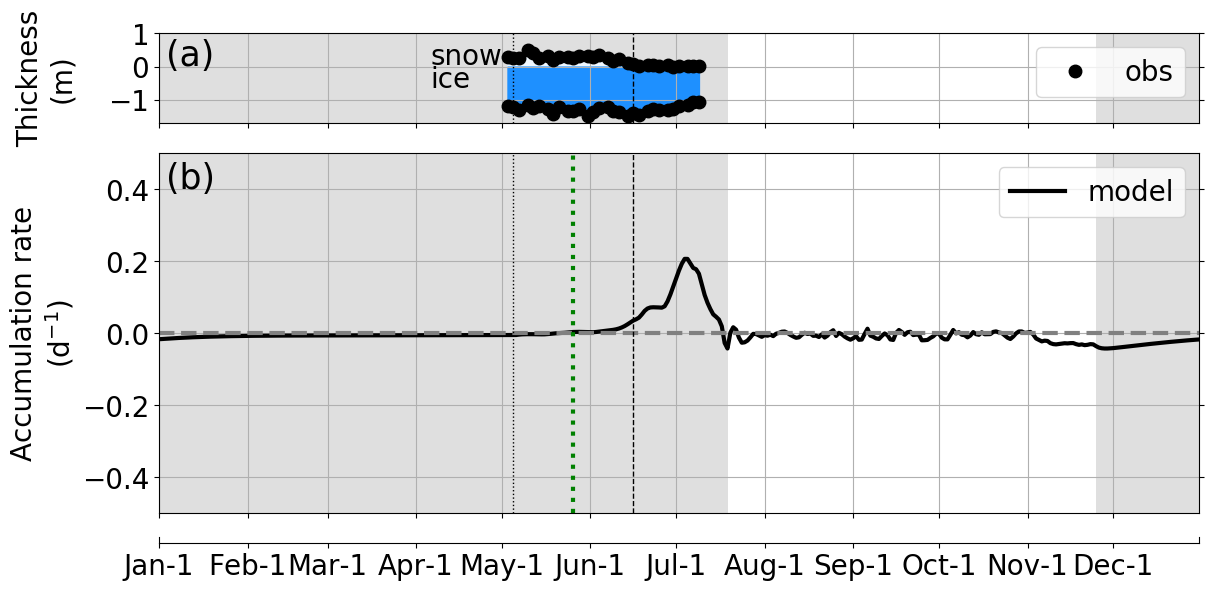

In [49]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.3,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.40,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.75,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')

    # --- ACCUMULATION RATE
    ax=axs[1]
    ymin=-0.5
    ymax= 0.5
    h1=ax.plot(first_year,array1d_iT_acc,
               '-',color='black',lw=3,label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Accumulation rate\n($\mathrm{ d^{-1} }$)')
    ax.grid()
    ax.legend(loc='upper right')
    ax.plot(xlims,[0,0],'k--',color='gray')
    plt.text(0.03,0.93,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,0.15])
    axs[1].set_position( [0.12,0.15  ,0.65,0.60])
    axs[2].set_position( [0.12,0.10  ,0.65,0.01])

with plt.style.context('thickness_PAR_nutrients_C_Chla_Kz_hBD_isolume.mplstyle'):
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(16,6))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='chl.0000000000.t001.r.png'
#     plt.savefig(outfile)

Figure <exp0_r>.
Model accumulation rates.
(a) Observed snow and ice thickness.
(b) Model accumulation rates for the reference simulation (EXP-0).

The vertical black dotted line is the date of the first PAR observations.
The vertical black dashed line is the date of the snow melt completion.
The green dotted line is the date of the simulated bloom initiation. 
The grey rectangles represent the time of year before the observed sea ice break-up and after the simulated sea ice freeze-up.

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated, 0-100m) chlorophyll $a$.

In [50]:
date_peak=np.nanargmax(array1d_iT_modvintchl)
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_peaks=\
datetime.datetime(year,1,1) + datetime.timedelta(date_peak.item())

Day of year

In [51]:
date_peak+1

198

In [52]:
date_peaks.strftime("%B %d")

'July 16'

In [53]:
c_P=array1d_iT_modvintchl[date_peak]

(in $mg\ Chl\ m^{-2}$)

In [54]:
c_P

50.474566663886435

### Model: $\mathrm{ \sum Chl\ } a$: EXP-1.2

In [55]:
indir_EXP1_2grp_Xmin_1Eminus0\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus0'
indir_EXP1_2grp_Xmin_1Eminus1\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus1'
indir_EXP1_2grp_Xmin_1Eminus2_default\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus2_default'
indir_EXP1_2grp_Xmin_1Eminus3\
='../run_20230825_0000_EXP1_2grp_Xmin_1Eminus3'
indir_EXP1_2grp_Xmin_0\
='../run_20230825_0000_EXP1_2grp_Xmin_0'
depth_end=100
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus0\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus0,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus1\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus1,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus2_default\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus2_default,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus3\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus3,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_0\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_0,
                        array1d_iT1y_iT,
                        depth_end)

# Plot

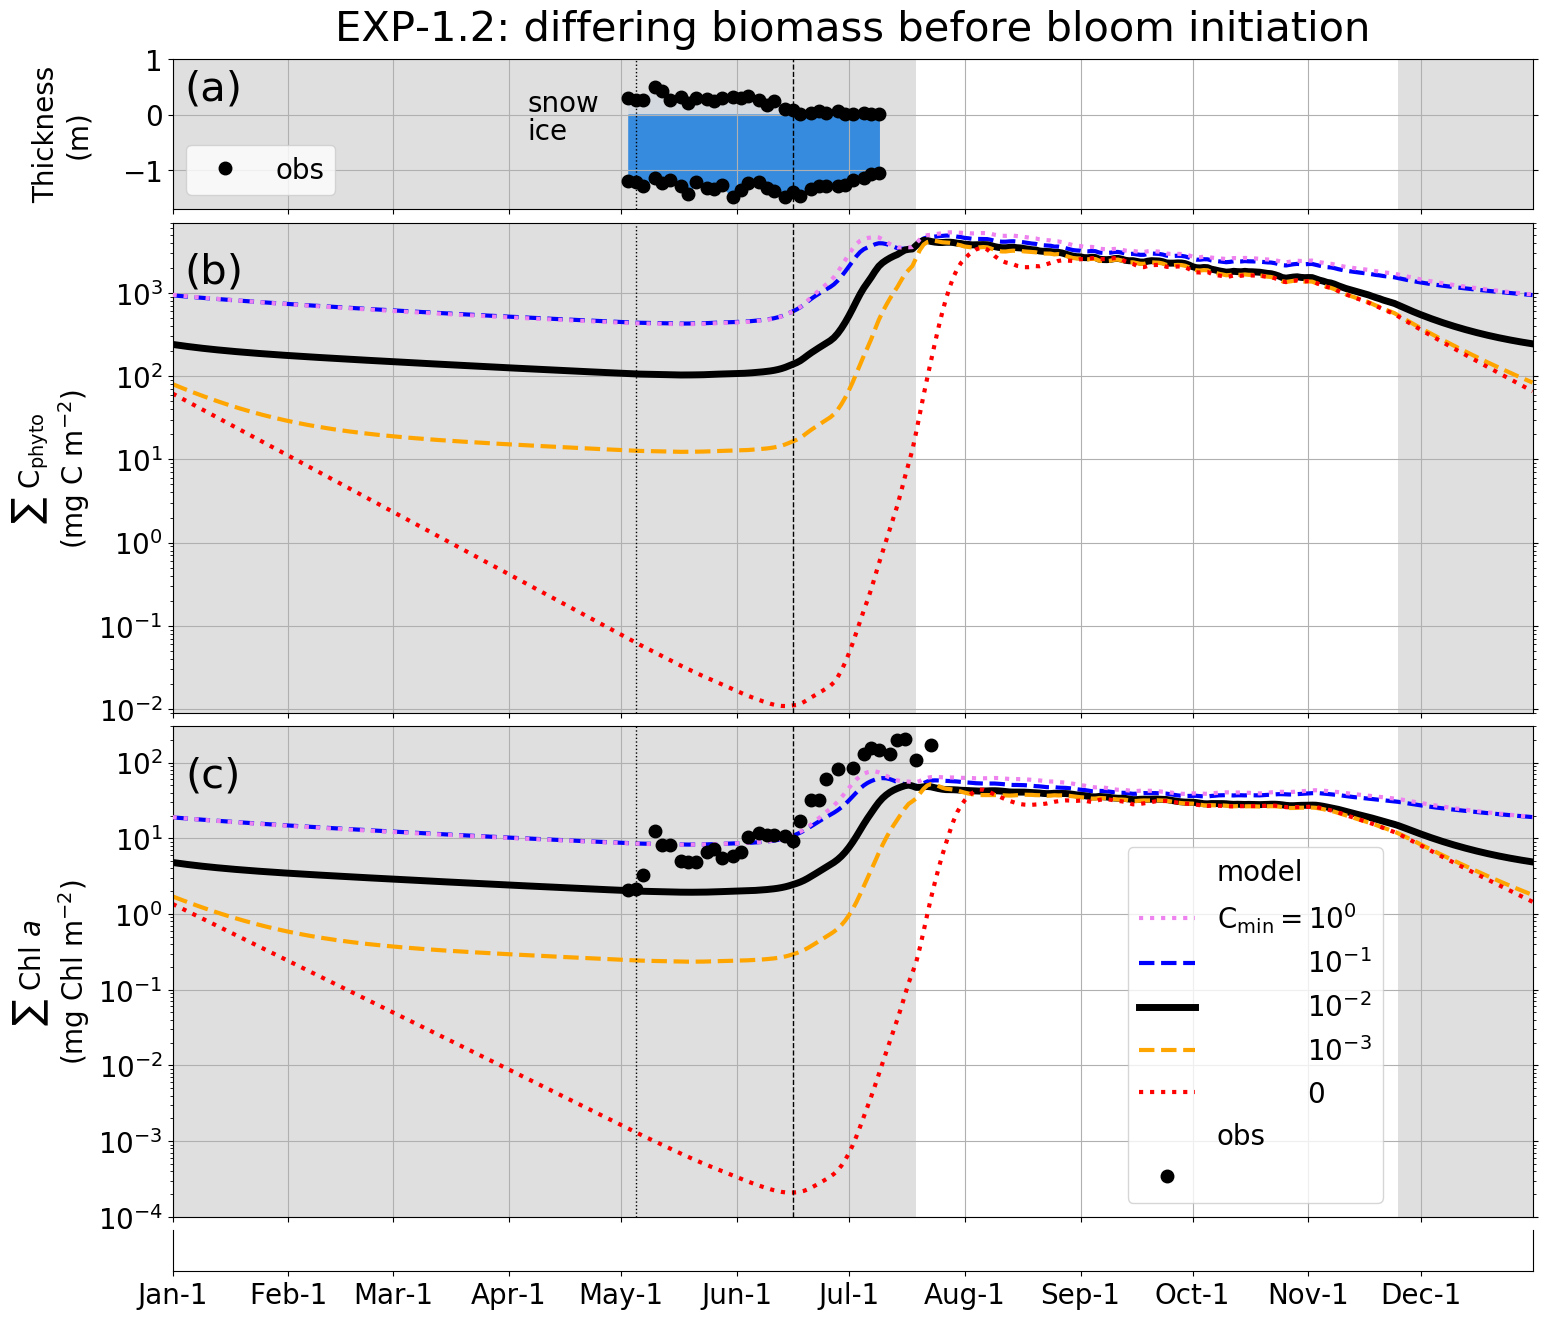

In [56]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.text(95,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    ax.legend(loc='lower left')
    plt.text(0.03,0.80,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-1.2: differing biomass before bloom initiation',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    
    # --- EXP-1.2: SUM C PHYTO
    ax=axs[1]
    h_off_model=ax.plot(0,1,
                  '-',color='black',alpha=0,label='model')
    h_EXP1_2grp_Xmin_1Eminus0=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus0,
        ':',color='violet',zorder=10)
    h_EXP1_2grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus1,
        '--',color='blue')
    h_EXP1_2grp_Xmin_1Eminus2_default=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus2_default,
        '-',color='black',linewidth=5)
    h_EXP1_2grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus3,
        '--',color='orange')
    h_EXP1_2grp_Xmin0=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_0,
        ':',color='red')
    ax.set_yscale('log')
    ymin=9E-3
    ymax=7000
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- EXP-1.2: SUM CHL A
    ax=axs[2]
    h_off_model=ax.plot(0,1,
                  '-',color='black',alpha=0,label='model')
    h_EXP1_2grp_Xmin_1Eminus0=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus0,
        ':',color='violet',zorder=10,
        label='$\mathrm{ C_{min}=10^{0} }$')
    h_EXP1_2grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus1,
        '--',color='blue',
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 10^{-1} }$')
    h_EXP1_2grp_Xmin_1Eminus2_default=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus2_default,
        '-',color='black',linewidth=5,
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 10^{-2} }$')
    h_EXP1_2grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus3,
        '--',color='orange',
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 10^{-3} }$')
    h_EXP1_2grp_Xmin_0=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_0,
        ':',color='red',
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 0       }$')
    h_off_obs=ax.plot(0,1,
                      '-',color='black',alpha=0,label='obs')
    h_obs=ax.plot(
        first_year,
        array1d_iT_obsvintchlHPLC,
        'o',color='black',zorder=10,label=' ')
    ax.set_yscale('log')
    ymin=1E-4
    ymax=300
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ Chl\ }a$\n'
                  '($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower right',bbox_to_anchor=(0.90,0.00))
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[3]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.82 ,0.85,0.11])
    axs[1].set_position( [0.13,0.45 ,0.85,0.36])
    axs[2].set_position( [0.13,0.08 ,0.85,0.36])
    axs[3].set_position( [0.13,0.04 ,0.85,0.03])

with plt.style.context('exp1.mplstyle'):
    # Plot
    fig,axs=plt.subplots(4,1,figsize=(16,13.62))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='exp1_2.png'
    plt.savefig(outfile)

Fig. \<exp1_2_total\>.
Sensitivity simulations: EXP-2 prescribed minimum biomass
($\mathrm{ C_{min} }$)
at $\mathrm{ 0 }$,
$\mathrm{ 10^{-3} }$,
$\mathrm{ 10^{-2} }$,
$\mathrm{ 10^{-1} }$ and
$\mathrm{ 10^{ 0}\ mmol\ C\ m^{-3}\ type^{-1} }$
for each of the 26 numerical phytoplankton types.
$\mathrm{ 10^{-2}\ mmol\ C\ m^{-3}\ type^{-1} }$
was the minimum biomass for the reference simulation
(complete black line).
This complete black line is the same output as shown in Fig.
\<validation\>d and e for the original ("reference") simulation.
(a) Observed snow and ice thickness.
(b) Vertically integrated biomass of phytoplankton (0-100m).
    Only model biomass is shown.
(c) Vertically integrated Chl a (0-100m).
    Dots are in situ Chl a.
    The lines are the model Chl a.
The vertical grey dotted line is the date of the first PAR observations.
The vertical grey dashed line is the date of the snow melt completion.
The grey rectangles represent the time of year before the sea ice
break-up and after the sea ice freeze-up.